In [122]:
import numpy as np
from numpy import random
import pickle
import os
import pathlib
from scipy.stats import gaussian_kde
from matplotlib import gridspec
import matplotlib.pyplot as plt

from Performance import DDR_Problem_Evaluation
ddr_eva = DDR_Problem_Evaluation()
from OLS import OLS_Related_Estimation
from DDR_Estimation import DDR_Method
from SPO import SPO_Plus_Method
from Data import DataSimulator
from Figure_Regret_H2H import Regret_H2H

## Generate Data

In [2]:
def generate_data(DataPath,iters,lower, upper, p, d, data_generation_process,
                  samples_test, samples_train, alpha, n_epsilon, mis, thres, x_dister, e_dister, xl, xu, xm, xv, bp):
    data_simu = DataSimulator()
    Data = {}
    for i in range(iters):
        # print("============== iteration = ",i,"==============")
        file_path = DataPath + "iter="+str(i) +"/"
        pathlib.Path(file_path).mkdir(parents=True, exist_ok=True)
        W_star = data_simu.generate_truth(lower, upper, p, d, data_generation_process) 
        Data[i] = data_simu.generate_samples(file_path,p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                            data_generation_process, x_dister, e_dister, xl, xu, xm, xv, bp) 
    return Data

## Oracle

In [3]:
def Implement_Oracle(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name
    cost_Oracle_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        cost_Oracle_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(z_test_ori,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 10 == 0:
        #     print(fold_name,",iteration = ",i,",c_oracle_without_noise = ",np.nanmean(cost_Oracle_wo_noise_all[i]))
    with open(Data_path_child+'cost_Oracle_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Oracle_wo_noise_all,tf)
    return cost_Oracle_wo_noise_all

## OLS

In [4]:
def Implement_OLS(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name
    ORE = OLS_Related_Estimation()
    cost_OLS_with_noise_all = {}; cost_OLS_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        W_ols, w0_ols, t_ols, obj_ols = ORE.OLS_Solver("",x_train, z_train)
        cost_pred = (W_ols @ x_test.T).T + w0_ols
        cost_OLS_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",c_OLS_without_noise = ",np.nanmean(cost_OLS_wo_noise_all[i]))
    with open(Data_path_child+'cost_OLS_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_OLS_wo_noise_all,tf)
    return cost_OLS_wo_noise_all

## Lasso

In [5]:
def Implement_Lasso(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name
    ORE = OLS_Related_Estimation()
    cost_Lasso_with_noise_all = {}; cost_Lasso_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        W_lasso, w0_lasso, t_lasso = ORE.Lasso_Solver(x_train, z_train)
        cost_pred = (W_lasso @ x_test.T).T + w0_lasso
        cost_Lasso_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",c_Lasso_without_noise = ",np.nanmean(cost_Lasso_wo_noise_all[i]))
    with open(Data_path_child+'cost_Lasso_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Lasso_wo_noise_all,tf)

    return cost_Lasso_wo_noise_all

## Ridge

In [6]:
def Implement_Ridge(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name

    ORE = OLS_Related_Estimation()
    cost_Ridge_with_noise_all = {}; cost_Ridge_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        W_ridge, w0_ridge, t_ridge = ORE.Ridge_Solver(x_train, z_train)
        cost_pred = (W_ridge @ x_test.T).T + w0_ridge
        cost_Ridge_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",c_Ridge_without_noise = ",np.nanmean(cost_Ridge_wo_noise_all[i]))

    with open(Data_path_child+'cost_Ridge_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Ridge_wo_noise_all,tf)

    return cost_Ridge_wo_noise_all

## DDR

In [7]:
def Implement_DDR(iters,Data,data_generation_process,DataPath,fold_name,mu_all,lamb_all):
    Data_path_child = DataPath + fold_name
    DDR_Esti = DDR_Method()
    W_ddr_all = {}; w0_ddr_all = {}; obj_ddr_all = {}
    cost_DDR_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        cost_ddr_avg_tem = np.zeros((len(mu_all),len(lamb_all)))
        for mu_index in range(len(mu_all)):
            mu = mu_all[mu_index]
            for lamb_index in range(len(lamb_all)):
                lamb = lamb_all[lamb_index]
                W_ddr_all[i,mu,lamb], w0_ddr_all[i,mu,lamb] = DDR_Esti.DDR_Solver(x_train, z_train, mu, lamb)
                cost_pred = (W_ddr_all[i,mu,lamb] @ x_test.T).T + w0_ddr_all[i,mu,lamb]
                cost_DDR_wo_noise_all[i,mu,lamb] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",cost_DDR_wo_noise_all = ",np.nanmean(cost_DDR_wo_noise_all[i,mu,lamb]))
    with open(Data_path_child+'cost_DDR_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_DDR_wo_noise_all,tf)

    return cost_DDR_wo_noise_all

## SPO Plus

In [8]:
def Implement_SPO_plus(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name
    SPM = SPO_Plus_Method()
    cost_SPO_with_noise_all = {}; cost_SPO_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        y_train_opt = ddr_eva.decision_finder(z_train) #generates the optimal y from the training costs
        W_spo, w0_spo, t_spo = SPM.SPO_Solver(x_train, z_train, y_train_opt)
        cost_pred = (W_spo @ x_test.T).T + w0_spo
        cost_SPO_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",cost_SPO_wo_noise_all = ",np.nanmean(cost_SPO_wo_noise_all[i]))
    with open(Data_path_child+'cost_SPO_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_SPO_wo_noise_all,tf)
    return cost_SPO_wo_noise_all

## Comparison

In [9]:
seed = 3
iters = 100
samples_test = 10000
thres = 100000000
lower = 0
upper = 1
n_epsilon = 1
mis = 1
x_dister = 'uniform'
e_dister = 'normal'
xl = -2
xu = 2
xm = 2
xv = 0.25
bp = 7

d = 10
alpha = 1
samples_train = 100
p = 4
mis_all = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0]

mu_all = np.round(np.arange(0.25,0.251,0.1),4)
lamb_all = np.round(np.arange(0.25,0.251,0.1),4)
data_generation_process = "DDR_Data_Generation"

current_directory = os.getcwd()
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(current_directory))))
DataPath = project_directory + "/Data_JOC_R1/DDR/Figure5/"
print("DataPath:", DataPath)
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/DDR/Figure5/


In [36]:
random.seed(seed)
mu = mu_all[0]
lamb = lamb_all[0]

cost_Oracle_all = {}
cost_OLS_all = {}
cost_DDR_all = {}
cost_SPO_all = {}
Data = {}
mis_index = 0
for mis in mis_all:
    
    fold_name = "samples_train="+str(samples_train)+"_p="+str(p)+"_d="+str(d)+"_alpha="+str(alpha)+"_mis="+str(mis)+"/"
    Data[mis] = generate_data(DataPath+fold_name,iters,lower, upper, p, d, data_generation_process,
        samples_test, samples_train, alpha, n_epsilon, mis, thres, x_dister, e_dister, xl, xu, xm, xv, bp)
    
    cost_Oracle_all[mis] = Implement_Oracle(iters,Data[mis],data_generation_process,DataPath,fold_name)
    cost_OLS_all[mis] = Implement_OLS(iters,Data[mis],data_generation_process,DataPath,fold_name)
    cost_DDR_all[mis] = Implement_DDR(iters,Data[mis],data_generation_process,DataPath,fold_name,mu_all,lamb_all)
    cost_SPO_all[mis] = Implement_SPO_plus(iters,Data[mis],data_generation_process,DataPath,fold_name)
    print("mis = ",mis)

mis =  0.4
mis =  0.6


/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Code_MacBook/Decision_Driven_Regularization/JOC_R1/DDR/Data.py:54: RuntimeWarning: invalid value encountered in power
  z_test_ori = np.power(np.dot(x_test, W_star.T) + bump * np.ones((samples_test, d)), mis)


mis =  0.8
mis =  1
mis =  1.2
mis =  1.4
mis =  1.8
mis =  2.0
mis =  2.5
mis =  3.0
mis =  3.5
mis =  4.0


In [47]:
mu = mu_all[0]
lamb = lamb_all[0]
h2h_ddr_ols = np.zeros(len(mis_all)); regret_ddr_ols = np.zeros(len(mis_all))
h2h_ddr_spo = np.zeros(len(mis_all)); regret_ddr_spo = np.zeros(len(mis_all))
h2h_ols_spo = np.zeros(len(mis_all)); regret_ols_spo = np.zeros(len(mis_all))

mis_index = 0
for mis in mis_all:
    win_ratio_ddr_ols_wo_noise = np.zeros(iters); cost_reduction_ddr_ols_wo_noise = np.zeros(iters); regret_reduction_ddr_ols_wo_noise = np.zeros(iters)
    win_ratio_ddr_spo_wo_noise = np.zeros(iters); cost_reduction_ddr_spo_wo_noise = np.zeros(iters); regret_reduction_ddr_spo_wo_noise = np.zeros(iters)
    win_ratio_ols_spo_wo_noise = np.zeros(iters); cost_reduction_ols_spo_wo_noise = np.zeros(iters); regret_reduction_ols_spo_wo_noise = np.zeros(iters)

    for i in range(iters):
        lbel, win_ratio_ddr_ols_wo_noise[i], cost_reduction_ddr_ols_wo_noise[i], regret_reduction_ddr_ols_wo_noise[i] = ddr_eva.cross_compare2plus(cost_DDR_all[mis][i,mu,lamb],cost_OLS_all[mis][i],cost_Oracle_all[mis][i])
        lbel, win_ratio_ddr_spo_wo_noise[i], cost_reduction_ddr_spo_wo_noise[i], regret_reduction_ddr_spo_wo_noise[i] = ddr_eva.cross_compare2plus(cost_DDR_all[mis][i,mu,lamb],cost_SPO_all[mis][i],cost_Oracle_all[mis][i])
        lbel, win_ratio_ols_spo_wo_noise[i], cost_reduction_ols_spo_wo_noise[i], regret_reduction_ols_spo_wo_noise[i] = ddr_eva.cross_compare2plus(cost_OLS_all[mis][i],cost_SPO_all[mis][i],cost_Oracle_all[mis][i])
    regret_ddr_ols[mis_index] = len(regret_reduction_ddr_ols_wo_noise[regret_reduction_ddr_ols_wo_noise > 0.0])/len(regret_reduction_ddr_ols_wo_noise)
    h2h_ddr_ols[mis_index] = len(win_ratio_ddr_ols_wo_noise[win_ratio_ddr_ols_wo_noise > 0.5])/len(win_ratio_ddr_ols_wo_noise)
    
    regret_ddr_spo[mis_index] = len(regret_reduction_ddr_spo_wo_noise[regret_reduction_ddr_spo_wo_noise > 0.0])/len(regret_reduction_ddr_spo_wo_noise)
    h2h_ddr_spo[mis_index] = len(win_ratio_ddr_spo_wo_noise[win_ratio_ddr_spo_wo_noise > 0.5])/len(win_ratio_ddr_spo_wo_noise)
    
    regret_ols_spo[mis_index] = len(regret_reduction_ols_spo_wo_noise[regret_reduction_ols_spo_wo_noise > 0.0])/len(regret_reduction_ols_spo_wo_noise)
    h2h_ols_spo[mis_index] = len(win_ratio_ols_spo_wo_noise[win_ratio_ols_spo_wo_noise > 0.5])/len(win_ratio_ols_spo_wo_noise)
    mis_index += 1

### Plot figure

/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_61483/3792293196.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')


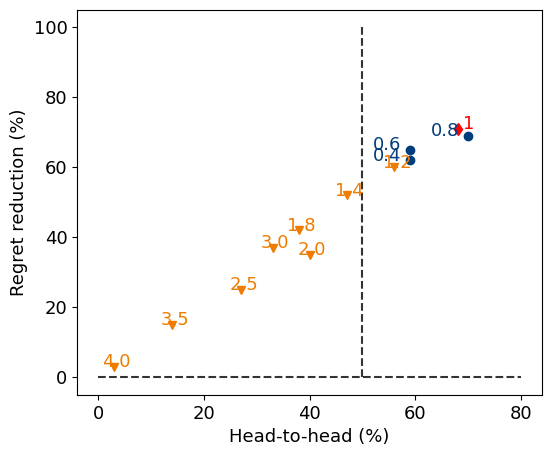

In [48]:
import matplotlib.pyplot as plt
h2h = h2h_ddr_ols * 100
pio = regret_ddr_ols * 100
mis = mis_all
plt.figure(figsize = (6,5))
plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')
for i in range(3):
    plt.text(h2h[i] - 7, pio[i] - 0.01,np.round(mis[i],1), color='#003D7C')

plt.plot(h2h[3], pio[3],'d', color='red')
plt.text(h2h[3] + 1, pio[3] - 0.02, np.round(mis[3],1), color='red')

plt.plot(h2h[4:7], pio[4:7],'v', color = '#EF7C00')
for i in range(4, 7):
    plt.text(h2h[i] - 2.2, pio[i] - 0.05, np.round(mis[i],1), color='#EF7C00')

plt.plot(h2h[7], pio[7],'v', color = '#EF7C00')
plt.text(h2h[7] - 2.2, pio[7] - 0.05, np.round(mis[7],1), color='#EF7C00')

plt.plot(h2h[8:12], pio[8:12],'v', color = '#EF7C00')
for i in range(8, 12):
       plt.text(h2h[i] - 2.2, pio[i] - 0.05, np.round(mis[i],1), color='#EF7C00')

plt.vlines(50, 0.0, 100, linestyle="dashed", alpha = 0.8, color = 'k')
plt.hlines(0.0, 0, 80, linestyle="dashed", alpha = 0.8, color = 'k')


plt.xlabel('Head-to-head (%)', fontsize=13)
plt.ylabel('Regret reduction (%)', fontsize=13)
plt.rcParams.update({'font.size': 13})

plt.savefig(DataPath + 'mis_ddr_ols.pdf', format='pdf', bbox_inches="tight")

/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_61483/2710138691.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')


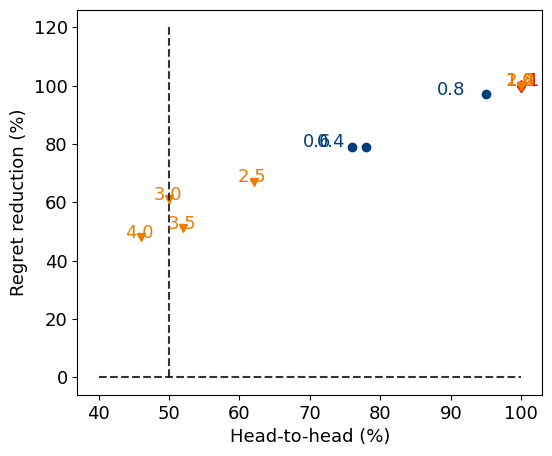

In [50]:
import matplotlib.pyplot as plt
h2h = h2h_ddr_spo * 100
pio = regret_ddr_spo * 100
mis = mis_all
plt.figure(figsize = (6,5))
plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')
for i in range(3):
    plt.text(h2h[i] - 7, pio[i] - 0.01,np.round(mis[i],1), color='#003D7C')

plt.plot(h2h[3], pio[3],'d', color='red')
plt.text(h2h[3] + 1, pio[3] - 0.02, np.round(mis[3],1), color='red')

plt.plot(h2h[4:7], pio[4:7],'v', color = '#EF7C00')
for i in range(4, 7):
    plt.text(h2h[i] - 2.2, pio[i] - 0.05, np.round(mis[i],1), color='#EF7C00')

plt.plot(h2h[7], pio[7],'v', color = '#EF7C00')
plt.text(h2h[7] - 2.2, pio[7] - 0.05, np.round(mis[7],1), color='#EF7C00')

plt.plot(h2h[8:12], pio[8:12],'v', color = '#EF7C00')
for i in range(8, 12):
       plt.text(h2h[i] - 2.2, pio[i] - 0.05, np.round(mis[i],1), color='#EF7C00')

plt.vlines(50, 0.0, 120, linestyle="dashed", alpha = 0.8, color = 'k')
plt.hlines(0, 40, 100, linestyle="dashed", alpha = 0.8, color = 'k')


plt.xlabel('Head-to-head (%)', fontsize=13)
plt.ylabel('Regret reduction (%)', fontsize=13)
plt.rcParams.update({'font.size': 13})

plt.savefig(DataPath + 'mis_ddr_spo.pdf', format='pdf', bbox_inches="tight")

/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_61483/1638687723.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')


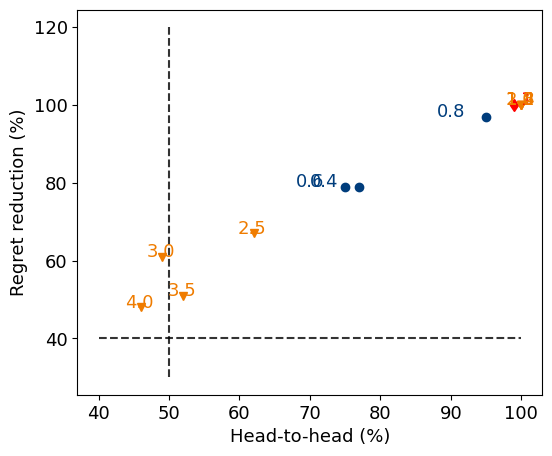

In [53]:
import matplotlib.pyplot as plt
h2h = h2h_ols_spo * 100
pio = regret_ols_spo * 100
mis = mis_all
plt.figure(figsize = (6,5))
plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')
for i in range(3):
    plt.text(h2h[i] - 7, pio[i] - 0.01,np.round(mis[i],1), color='#003D7C')

plt.plot(h2h[3], pio[3],'d', color='red')
plt.text(h2h[3] + 1, pio[3] - 0.02, np.round(mis[3],1), color='red')

plt.plot(h2h[4:7], pio[4:7],'v', color = '#EF7C00')
for i in range(4, 7):
    plt.text(h2h[i] - 2.2, pio[i] - 0.05, np.round(mis[i],1), color='#EF7C00')

plt.plot(h2h[7], pio[7],'v', color = '#EF7C00')
plt.text(h2h[7] - 2.2, pio[7] - 0.05, np.round(mis[7],1), color='#EF7C00')

plt.plot(h2h[8:12], pio[8:12],'v', color = '#EF7C00')
for i in range(8, 12):
       plt.text(h2h[i] - 2.2, pio[i] - 0.05, np.round(mis[i],1), color='#EF7C00')

plt.vlines(50, 30.0, 120, linestyle="dashed", alpha = 0.8, color = 'k')
plt.hlines(40, 40, 100, linestyle="dashed", alpha = 0.8, color = 'k')


plt.xlabel('Head-to-head (%)', fontsize=13)
plt.ylabel('Regret reduction (%)', fontsize=13)
plt.rcParams.update({'font.size': 13})

plt.savefig(DataPath + 'mis_ols_spo.pdf', format='pdf', bbox_inches="tight")

#### Head-to-head

In [55]:
mis = 1.8
win_ratio_ddr_ols_wo_noise = np.zeros(iters); cost_reduction_ddr_ols_wo_noise = np.zeros(iters); regret_reduction_ddr_ols_wo_noise = np.zeros(iters)
win_ratio_ddr_spo_wo_noise = np.zeros(iters); cost_reduction_ddr_spo_wo_noise = np.zeros(iters); regret_reduction_ddr_spo_wo_noise = np.zeros(iters)
win_ratio_ols_spo_wo_noise = np.zeros(iters); cost_reduction_ols_spo_wo_noise = np.zeros(iters); regret_reduction_ols_spo_wo_noise = np.zeros(iters)

for i in range(iters):
    lbel, win_ratio_ddr_ols_wo_noise[i], cost_reduction_ddr_ols_wo_noise[i], regret_reduction_ddr_ols_wo_noise[i] = ddr_eva.cross_compare2plus(cost_DDR_all[mis][i,mu,lamb],cost_OLS_all[mis][i],cost_Oracle_all[mis][i])
    lbel, win_ratio_ddr_spo_wo_noise[i], cost_reduction_ddr_spo_wo_noise[i], regret_reduction_ddr_spo_wo_noise[i] = ddr_eva.cross_compare2plus(cost_DDR_all[mis][i,mu,lamb],cost_SPO_all[mis][i],cost_Oracle_all[mis][i])
    lbel, win_ratio_ols_spo_wo_noise[i], cost_reduction_ols_spo_wo_noise[i], regret_reduction_ols_spo_wo_noise[i] = ddr_eva.cross_compare2plus(cost_OLS_all[mis][i],cost_SPO_all[mis][i],cost_Oracle_all[mis][i])


#### DDR_vs_SPO

In [105]:
size = (5, 5)
move = [0.65, 0.85, 0.65, 0.85]
ysame = 0
yrange = [6,6]
sublabel = ''
ypio = 0
all_x = win_ratio_ddr_spo_wo_noise*100
all_y = regret_reduction_ddr_spo_wo_noise*100
ymin=0
ymax=100
xmin=0
xmax=100
figure_name = DataPath + 'ddr_spo'

Text(0.85, 0.15, '1.0')

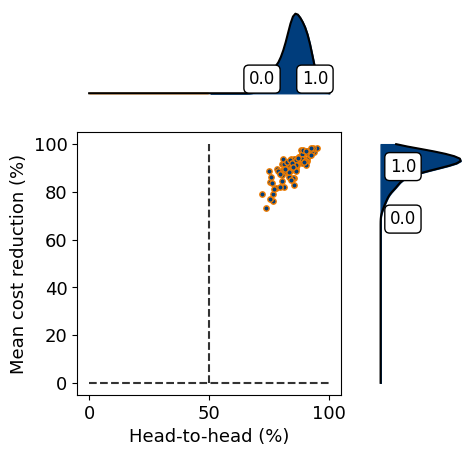

In [106]:
data = np.asarray([all_x,all_y])
####### Obtain KDE  

#KDE for top marginal
kde_X = gaussian_kde(data[0])
#KDE for right marginal
kde_Y = gaussian_kde(data[1])

x = np.linspace(0, 100, 100)
y = np.linspace(ymin, ymax, 100)

dx = kde_X(x) # X-marginal density
dy = kde_Y(y) # Y-marginal density

#Define grid for subplots
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios = [1, 3])

####### Create scatter plot
fig = plt.figure(figsize = size)
ax = plt.subplot(gs[1, 0])
cax = ax.scatter(data[0], data[1], s = 15, color='#003D7C', marker = "o", edgecolors = "#EF7C00")
plt.xlabel('Head-to-head (%)')
plt.ylabel('Mean cost reduction (%)') #pio

plt.vlines(50, ymin, ymax, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0, xmin, xmax, linestyle="dashed", alpha = 0.8,color = 'k')
# ax.annotate(sublabel, xy = (0.55,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# ####### Create Y-marginal (right)
axr = plt.subplot(gs[1, 1], xticks = [], yticks = [], frameon = False)
axr.plot(dy, y, color = 'black')
axr.fill_betweenx(y, 0, dy, where = y <= 0.01, alpha = 1, color='#EF7C00')
axr.fill_betweenx(y, 0, dy, where = y >= 0, alpha = 1, color='#003D7C')
leftarea = np.round( sum(n <= 0 for n in all_y)/len(all_y),2 )
rightarea = np.round( sum(n > 0 for n in all_y)/len(all_y),2 )

axr.annotate(leftarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[0]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
axr.annotate(rightarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[1]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)

# ####### Create X-marginal (top)
axt = plt.subplot(gs[0,0], frameon = False, yticks = [], xticks = [])
axt.plot(x, dx, color = 'black')
axt.fill_between(x, 0, dx, where = x >= 49.9, alpha= 1, color = '#003D7C')
axt.fill_between(x, 0, dx, where = x <= 50, alpha= 1, color = '#EF7C00')
leftarea = np.round( sum(n <= 50 for n in all_x)/len(all_x),2 )
rightarea = np.round( sum(n > 50 for n in all_x)/len(all_x),2 )
axt.annotate(leftarea, xy=(move[2], 0.15), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
axt.annotate(rightarea, xy=(move[3], 0.15), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)

# ####### Bring the marginals closer to the scatter plot and save eps file
# fig.tight_layout(pad = 1)
# plt.savefig(figure_name + '.eps', format='eps')
# plt.savefig(figure_name + '.pdf', format='pdf')

#### OLS vs SPO

In [103]:
size = (5, 5)
move = [0.65, 0.85, 0.65, 0.85]
ysame = 0
yrange = [6,6]
sublabel = ''
ypio = 0
all_x = win_ratio_ols_spo_wo_noise*100
all_y = regret_reduction_ols_spo_wo_noise*100
ymin=0
ymax=100
xmin=0
xmax=100
figure_name = DataPath + 'ols_spo'

Text(0.85, 0.15, '1.0')

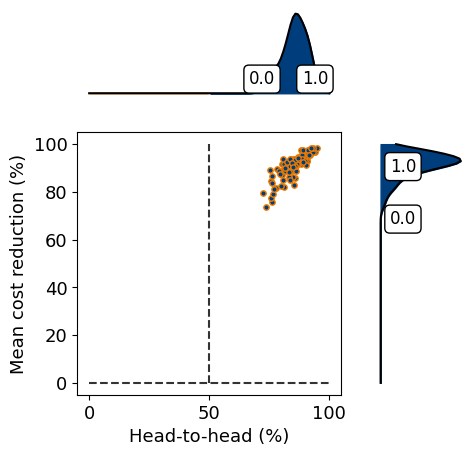

In [104]:
data = np.asarray([all_x,all_y])
ymin=0
ymax=100
xmin=0
xmax=100

####### Obtain KDE  

#KDE for top marginal
kde_X = gaussian_kde(data[0])
#KDE for right marginal
kde_Y = gaussian_kde(data[1])

x = np.linspace(0, 100, 100)
y = np.linspace(ymin, ymax, 100)

dx = kde_X(x) # X-marginal density
dy = kde_Y(y) # Y-marginal density

#Define grid for subplots
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios = [1, 3])

####### Create scatter plot
fig = plt.figure(figsize = size)
ax = plt.subplot(gs[1, 0])
cax = ax.scatter(data[0], data[1], s = 15, color='#003D7C', marker = "o", edgecolors = "#EF7C00")
plt.xlabel('Head-to-head (%)')
plt.ylabel('Mean cost reduction (%)') #pio

plt.vlines(50, ymin, ymax, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0, xmin, xmax, linestyle="dashed", alpha = 0.8,color = 'k')
# ax.annotate(sublabel, xy = (0.55,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# ####### Create Y-marginal (right)
axr = plt.subplot(gs[1, 1], xticks = [], yticks = [], frameon = False)
axr.plot(dy, y, color = 'black')
axr.fill_betweenx(y, 0, dy, where = y <= 0.01, alpha = 1, color='#EF7C00')
axr.fill_betweenx(y, 0, dy, where = y >= 0, alpha = 1, color='#003D7C')
leftarea = np.round( sum(n <= 0 for n in all_y)/len(all_y),2 )
rightarea = np.round( sum(n > 0 for n in all_y)/len(all_y),2 )

axr.annotate(leftarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[0]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
axr.annotate(rightarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[1]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)

# ####### Create X-marginal (top)
axt = plt.subplot(gs[0,0], frameon = False, yticks = [], xticks = [])
axt.plot(x, dx, color = 'black')
axt.fill_between(x, 0, dx, where = x >= 49.9, alpha= 1, color = '#003D7C')
axt.fill_between(x, 0, dx, where = x <= 50, alpha= 1, color = '#EF7C00')
leftarea = np.round( sum(n <= 50 for n in all_x)/len(all_x),2 )
rightarea = np.round( sum(n > 50 for n in all_x)/len(all_x),2 )
axt.annotate(leftarea, xy=(move[2], 0.15), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
axt.annotate(rightarea, xy=(move[3], 0.15), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)

# ####### Bring the marginals closer to the scatter plot and save eps file
# fig.tight_layout(pad = 1)
# plt.savefig(figure_name + '.eps', format='eps')
# plt.savefig(figure_name + '.pdf', format='pdf')

### misspecification coef $\beta = 3.0$

In [119]:
mis = 3.0
win_ratio_ddr_ols_wo_noise = np.zeros(iters); cost_reduction_ddr_ols_wo_noise = np.zeros(iters); regret_reduction_ddr_ols_wo_noise = np.zeros(iters)
win_ratio_ddr_spo_wo_noise = np.zeros(iters); cost_reduction_ddr_spo_wo_noise = np.zeros(iters); regret_reduction_ddr_spo_wo_noise = np.zeros(iters)
win_ratio_ols_spo_wo_noise = np.zeros(iters); cost_reduction_ols_spo_wo_noise = np.zeros(iters); regret_reduction_ols_spo_wo_noise = np.zeros(iters)

for i in range(iters):
    lbel, win_ratio_ddr_ols_wo_noise[i], cost_reduction_ddr_ols_wo_noise[i], regret_reduction_ddr_ols_wo_noise[i] = ddr_eva.cross_compare2plus(cost_DDR_all[mis][i,mu,lamb],cost_OLS_all[mis][i],cost_Oracle_all[mis][i])
    lbel, win_ratio_ddr_spo_wo_noise[i], cost_reduction_ddr_spo_wo_noise[i], regret_reduction_ddr_spo_wo_noise[i] = ddr_eva.cross_compare2plus(cost_DDR_all[mis][i,mu,lamb],cost_SPO_all[mis][i],cost_Oracle_all[mis][i])
    lbel, win_ratio_ols_spo_wo_noise[i], cost_reduction_ols_spo_wo_noise[i], regret_reduction_ols_spo_wo_noise[i] = ddr_eva.cross_compare2plus(cost_OLS_all[mis][i],cost_SPO_all[mis][i],cost_Oracle_all[mis][i])

In [120]:
size = (5, 5)
move = [0.65, 0.85, 0.65, 0.85]
ysame = 0
yrange = [6,6]
sublabel = ''
ypio = 0
all_x = win_ratio_ols_spo_wo_noise*100
all_y = regret_reduction_ols_spo_wo_noise*100
ymin=0
ymax=100
xmin=0
xmax=100
figure_name = DataPath + 'ols_spo'

Text(0.85, 0.15, '0.49')

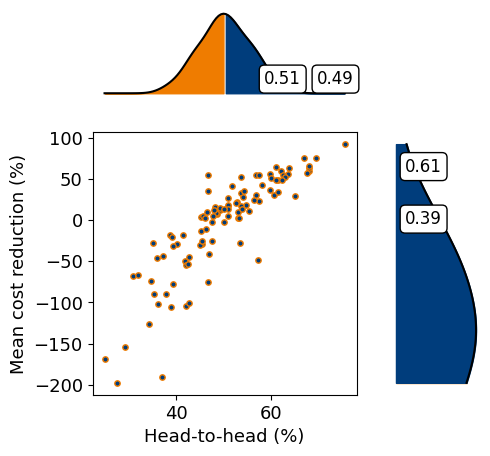

In [121]:
data = np.asarray([all_x,all_y])
####### Obtain KDE  

#KDE for top marginal
kde_X = gaussian_kde(data[0])
#KDE for right marginal
kde_Y = gaussian_kde(data[1])

x = np.linspace(0, 100, 100)
y = np.linspace(ymin, ymax, 100)

dx = kde_X(x) # X-marginal density
dy = kde_Y(y) # Y-marginal density

#Define grid for subplots
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios = [1, 3])

####### Create scatter plot
fig = plt.figure(figsize = size)
ax = plt.subplot(gs[1, 0])
cax = ax.scatter(data[0], data[1], s = 15, color='#003D7C', marker = "o", edgecolors = "#EF7C00")
plt.xlabel('Head-to-head (%)')
plt.ylabel('Mean cost reduction (%)') #pio

# plt.vlines(50, ymin, ymax, linestyle="dashed", alpha = 0.8,color = 'k')
# plt.hlines(0, xmin, xmax, linestyle="dashed", alpha = 0.8,color = 'k')
# ax.annotate(sublabel, xy = (0.55,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# ####### Create Y-marginal (right)
axr = plt.subplot(gs[1, 1], xticks = [], yticks = [], frameon = False)
axr.plot(dy, y, color = 'black')
axr.fill_betweenx(y, 0, dy, where = y <= 0.01, alpha = 1, color='#EF7C00')
axr.fill_betweenx(y, 0, dy, where = y >= 0, alpha = 1, color='#003D7C')
leftarea = np.round( sum(n <= 0 for n in all_y)/len(all_y),2 )
rightarea = np.round( sum(n > 0 for n in all_y)/len(all_y),2 )

axr.annotate(leftarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[0]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
axr.annotate(rightarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[1]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)

# ####### Create X-marginal (top)
axt = plt.subplot(gs[0,0], frameon = False, yticks = [], xticks = [])
axt.plot(x, dx, color = 'black')
axt.fill_between(x, 0, dx, where = x >= 49.9, alpha= 1, color = '#003D7C')
axt.fill_between(x, 0, dx, where = x <= 50, alpha= 1, color = '#EF7C00')
leftarea = np.round( sum(n <= 50 for n in all_x)/len(all_x),2 )
rightarea = np.round( sum(n > 50 for n in all_x)/len(all_x),2 )
axt.annotate(leftarea, xy=(move[2], 0.15), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
axt.annotate(rightarea, xy=(move[3], 0.15), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)

# ####### Bring the marginals closer to the scatter plot and save eps file
# fig.tight_layout(pad = 1)
# plt.savefig(figure_name + '.eps', format='eps')
# plt.savefig(figure_name + '.pdf', format='pdf')